In [1]:
from PID import dxdt, y_f, x_next
from PID import *
import matplotlib.pyplot as plt 
import optuna
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, GRU, Input
import numpy as np 
import openpyxl
from openpyxl import Workbook, load_workbook

In [4]:
class Scaler:
    def __init__(self):
        self.min_vals: list[float] = None
        self.max_vals: list[float] = None

    def fit(self, X_train):
        
        self.min_vals = np.empty(X_train.shape[-1])
        self.max_vals = np.empty(X_train.shape[-1])
        
        for s in range(X_train.shape[-1]):
            self.min_vals[s] = np.min(X_train[:,:,s])
            self.max_vals[s] = np.max(X_train[:,:,s])
            
        return

    def transform(self, X):
        try:
            X_copy = np.copy(X)
            for s in range(X_copy.shape[-1]):
                X_copy[:,:,s] = (X[:,:,s] - self.min_vals[s]) / (self.max_vals[s] - self.min_vals[s])
        except:
            raise Execption("Not Fited!!!")
            
        return X_copy

    def __str__(self):
        return f"min_vals:{self.min_vals}\nmax_vals:{self.max_vals}"

    def __call__(self,X):
        return self.transform(X) 


        
def data_to_X_Y(data, window_size=2):
    
    x = []
    y = []
    
    for i in range(len(data) - window_size):
        row = [r for r in data[i:i+window_size]]  
        x.append(row)
        label = data[i+window_size][-1]
        y.append(label)
    return np.array(x), np.array(y)
        
def create_model(params: dict):
    """
    Function that automates the creation of a model based
    on the params input
    """
    
    n = params["nhidden"]
    fun1 = params["activation1"]
    l1 = params["l1"]
    l2 = params["l2"]
    dropout_rate = params["dropout_rate"]
    
    model = Sequential()
    model.add(Input((None, 3)))
    model.add(GRU(n,activation=fun1, kernel_regularizer=keras.regularizers.L1L2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(
        loss = "mse",
        optimizer = keras.optimizers.Adam(learning_rate=0.001)
    )

    return model

def get_offline_error(k, model):
    dt = 0.5
    t_sim = np.arange(0, 100, dt)
    
    X_off = np.zeros((t_sim.shape[0], 2))
    U_off = np.zeros((t_sim.shape[0], 2))
    Y_off = np.zeros(t_sim.shape[0])
    Y_pred = np.zeros(t_sim.shape[0])
    
    X_off[0, :] = [Wa, Wb]
    Y_off[0] = y_f(X_off[0], x0=7.0)
    Y_pred[0] = Y_off[0]
    U_off[:, :] = [u1ss, u2ss]
    
    U_off[20:, 0] *= 1.25
    U_off[100:, 1] *= 20
    
    for n in range(0, t_sim.shape[0] - 1):
        X_off[n + 1, :] = x_next(X_off[n], U_off[n], dt)
        Y_off[n + 1] = y_f(X_off[n + 1], x0=Y_off[n])
    
    Y_pred[: k + 1] = Y_off[: k + 1]
    
    for n in range(k, t_sim.shape[0] - 1):
        data_input = np.column_stack((U_off[n - k : n], Y_pred[n - k : n]))
        model_input = pre(data_input.reshape(-1, k, 3))
        Y_pred[n + 1] = float(model.predict(model_input, verbose=0)[0,0])

    score = mse(Y_off, Y_pred)
    return score

def mse(y1, y2):
    return np.mean(np.square(y1 - y2))

def tuna_obj(trial):

    # Decision variables
    n = trial.suggest_int('n_hidden', 1, 50)
    fun1 = trial.suggest_categorical("activation function", ["tanh", "linear"])
    window_size = trial.suggest_int("window_size", 1, 4)
    tuna_params = {
        "nhidden": n,
        "activation1": fun1,
        "window_size": window_size,
        "l1": trial.suggest_float("l1", 1e-9, 1e-2, log=True),
        "l2": trial.suggest_float("l2", 1e-9, 1e-2, log=True),
        "dropout_rate": trial.suggest_float("dr", 0.0, 0.5, step=.01),
    }
    
    tuna_model = create_model(tuna_params)

    x_tuna, y_tuna = data_to_X_Y(dataset_train, window_size = window_size)
    pre.fit(x_tuna)
    x2, y2 = data_to_X_Y(dataset_test, window_size=window_size)
    xN = pre(x_tuna)
    # fit model
    callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
    tuna_model.fit(xN, y_tuna, validation_split=0.25, batch_size=64, epochs=30, callbacks=[callback],verbose=0)
    final_loss = tuna_model.history.history["loss"][-1]
    final_val_loss = tuna_model.history.history["val_loss"][-1]
    test_loss = mse(tuna_model.predict(pre(x2)), y2)
    offline_score = get_offline_error(window_size, tuna_model)
    try:
        wb = load_workbook(filename)
        ws = wb.active
        ws.append(list(tuna_params.values()) + [final_loss, final_val_loss, test_loss, offline_score])
        wb.save(filename)
        wb.close()
    except:
        wb = Workbook()
        ws = wb.active
        ws.title = "GRU"
        ws.append(list(tuna_params.keys()) + ["train loss", "val loss", "test loss", "offline loss"])
        ws.append(list(tuna_params.values()) + [final_loss, final_val_loss, test_loss, offline_score])
        wb.save(filename)
        wb.close()
        
    # Exporting best model
    trial.set_user_attr('tuna_params', tuna_params)
    trial.set_user_attr('model', tuna_model)
    
    return offline_score

In [9]:
# Data Loading
print("LOADING DATA")
dataset_train = np.loadtxt("data/PID_data.csv", delimiter=",")
dataset_test = np.loadtxt("data/PID_data_test.csv", delimiter=",")

t = dataset_train[:,0]
t2 = dataset_test[:,0]

dt = t[1] - t[0]

dataset_train = dataset_train[:, 1:]
dataset_test = dataset_test[:, 1:]

x_train, _ = data_to_X_Y(dataset_train)

pre = Scaler()
pre.fit(x_train)

print(pre)

filename = "results/GRU/modeling.xlsx"

print("DATA LOADED")

LOADING DATA
min_vals:[7.77500000e+00 5.54058448e-03 5.71566559e+00]
max_vals:[23.325       4.98602873  9.48785654]
DATA LOADED


In [10]:
minimal_params = {
    "n_hdden":1,
    "activation function": "tanh",
    "l1":1e-9,
    "l2":1e-9,
    "dr":0.0,
    "window_size":1
}

In [11]:
import pickle 
try:
    with open("tuna_study.obj", "rb") as file:
        study = pickle.load(file)
except:
    study = optuna.create_study()
    study.enqueue_trial(minimal_params)
    
study.optimize(tuna_obj, timeout=60*19) #timeout = seconds to run

with open("tuna_study.obj", "wb") as file:
    pickle.dump(study, file)

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step


[I 2024-07-24 10:03:31,794] Trial 61 finished with value: 0.1764407212671773 and parameters: {'n_hidden': 43, 'activation function': 'tanh', 'window_size': 3, 'l1': 0.0002678303606517285, 'l2': 3.920514524221786e-05, 'dr': 0.34}. Best is trial 12 with value: 0.061817585995646435.


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 902us/step


[I 2024-07-24 10:04:48,105] Trial 62 finished with value: 0.38991899707187777 and parameters: {'n_hidden': 46, 'activation function': 'tanh', 'window_size': 3, 'l1': 0.0005370887147361211, 'l2': 0.00012743150401075705, 'dr': 0.36}. Best is trial 12 with value: 0.061817585995646435.


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step


[I 2024-07-24 10:06:02,362] Trial 63 finished with value: 1.723667328477474 and parameters: {'n_hidden': 32, 'activation function': 'tanh', 'window_size': 3, 'l1': 8.35745755482917e-06, 'l2': 1.1058706700773113e-05, 'dr': 0.32}. Best is trial 12 with value: 0.061817585995646435.


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step


[I 2024-07-24 10:07:24,280] Trial 64 finished with value: 0.1904594124671037 and parameters: {'n_hidden': 41, 'activation function': 'tanh', 'window_size': 3, 'l1': 0.00011798772009964556, 'l2': 0.0003039851530296634, 'dr': 0.33}. Best is trial 12 with value: 0.061817585995646435.


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step


[I 2024-07-24 10:08:37,059] Trial 65 finished with value: 1.0105715018914874 and parameters: {'n_hidden': 36, 'activation function': 'tanh', 'window_size': 3, 'l1': 0.0002967907951204257, 'l2': 2.5896804419537032e-06, 'dr': 0.29}. Best is trial 12 with value: 0.061817585995646435.


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step


[I 2024-07-24 10:09:33,799] Trial 66 finished with value: 0.22986992264067968 and parameters: {'n_hidden': 25, 'activation function': 'linear', 'window_size': 1, 'l1': 0.0035026326640951112, 'l2': 6.14560049968647e-05, 'dr': 0.0}. Best is trial 12 with value: 0.061817585995646435.


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step


[I 2024-07-24 10:10:48,998] Trial 67 finished with value: 0.1261849899779704 and parameters: {'n_hidden': 29, 'activation function': 'tanh', 'window_size': 3, 'l1': 0.0016355575250703643, 'l2': 6.840885013108313e-08, 'dr': 0.41000000000000003}. Best is trial 12 with value: 0.061817585995646435.


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step


[I 2024-07-24 10:11:53,978] Trial 68 finished with value: 0.21210408155384392 and parameters: {'n_hidden': 29, 'activation function': 'tanh', 'window_size': 2, 'l1': 0.0017445172001620403, 'l2': 8.181496762785045e-08, 'dr': 0.43}. Best is trial 12 with value: 0.061817585995646435.


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step


[I 2024-07-24 10:13:11,707] Trial 69 finished with value: 0.5196974787075115 and parameters: {'n_hidden': 23, 'activation function': 'linear', 'window_size': 4, 'l1': 0.006094187716724814, 'l2': 1.6190152170439308e-08, 'dr': 0.4}. Best is trial 12 with value: 0.061817585995646435.


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step


[I 2024-07-24 10:14:09,187] Trial 70 finished with value: 0.8443504524781191 and parameters: {'n_hidden': 21, 'activation function': 'tanh', 'window_size': 1, 'l1': 0.0007124344487002155, 'l2': 4.013193049487693e-09, 'dr': 0.47000000000000003}. Best is trial 12 with value: 0.061817585995646435.


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step


[I 2024-07-24 10:15:18,453] Trial 71 finished with value: 0.8551433950972438 and parameters: {'n_hidden': 27, 'activation function': 'tanh', 'window_size': 3, 'l1': 0.002039872767409384, 'l2': 3.307185438553542e-08, 'dr': 0.36}. Best is trial 12 with value: 0.061817585995646435.


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step


[I 2024-07-24 10:16:30,404] Trial 72 finished with value: 0.431585088507189 and parameters: {'n_hidden': 34, 'activation function': 'tanh', 'window_size': 3, 'l1': 0.0011696511942635944, 'l2': 8.05973324392025e-06, 'dr': 0.04}. Best is trial 12 with value: 0.061817585995646435.


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step


[I 2024-07-24 10:17:38,413] Trial 73 finished with value: 1.575650380764941 and parameters: {'n_hidden': 30, 'activation function': 'tanh', 'window_size': 3, 'l1': 6.866694370495965e-05, 'l2': 1.5412076006896494e-05, 'dr': 0.35000000000000003}. Best is trial 12 with value: 0.061817585995646435.


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step


[I 2024-07-24 10:18:50,400] Trial 74 finished with value: 0.3205963444471317 and parameters: {'n_hidden': 46, 'activation function': 'tanh', 'window_size': 3, 'l1': 0.0038944598765756687, 'l2': 4.5634543425154306e-05, 'dr': 0.42}. Best is trial 12 with value: 0.061817585995646435.


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step


[I 2024-07-24 10:20:04,148] Trial 75 finished with value: 0.5643094385861699 and parameters: {'n_hidden': 48, 'activation function': 'tanh', 'window_size': 3, 'l1': 3.0768216525547425e-05, 'l2': 4.911548856893051e-07, 'dr': 0.19}. Best is trial 12 with value: 0.061817585995646435.


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step


[I 2024-07-24 10:21:21,954] Trial 76 finished with value: 0.6434479231309043 and parameters: {'n_hidden': 24, 'activation function': 'tanh', 'window_size': 2, 'l1': 0.0002922277216596668, 'l2': 2.1622670405246287e-07, 'dr': 0.12}. Best is trial 12 with value: 0.061817585995646435.


In [17]:
# Obtaining the best model and saving it
best_trial = study.best_trial
best_model = best_trial.user_attrs['model']
best_model.save('models/best_model.keras')

# Saving its best parameters
best_params = best_trial.user_attrs['tuna_params']
with open('models/best_model_params.txt', 'w') as f:
    for key, value in best_params.items():
        f.write(f'{key}: {value}\n')

In [13]:
dt = 0.5
k = best_params["window_size"]
t_sim = np.arange(0, 100, dt)

X_off = np.zeros((t_sim.shape[0], 2))
U_off = np.zeros((t_sim.shape[0], 2))
Y_off = np.zeros(t_sim.shape[0])
Y_pred = np.zeros(t_sim.shape[0])

X_off[0, :] = [Wa, Wb]
Y_off[0] = y_f(X_off[0], x0=7.0)
Y_pred[0] = Y_off[0]
U_off[:, :] = [u1ss, u2ss]

U_off[20:, 0] *= 1.25
U_off[100:, 1] *= 20

for n in range(0, t_sim.shape[0] - 1):
    X_off[n + 1, :] = x_next(X_off[n], U_off[n], dt)
    Y_off[n + 1] = y_f(X_off[n + 1], x0=Y_off[n])

Y_pred[: k + 1] = Y_off[: k + 1]

for n in range(k, t_sim.shape[0] - 1):
    data_input = np.column_stack((U_off[n - k : n], Y_pred[n - k : n]))
    model_input = pre(data_input.reshape(-1, k, 3))
    Y_pred[n + 1] = float(best_model.predict(model_input, verbose=0)[0,0])

0.061817585995646435


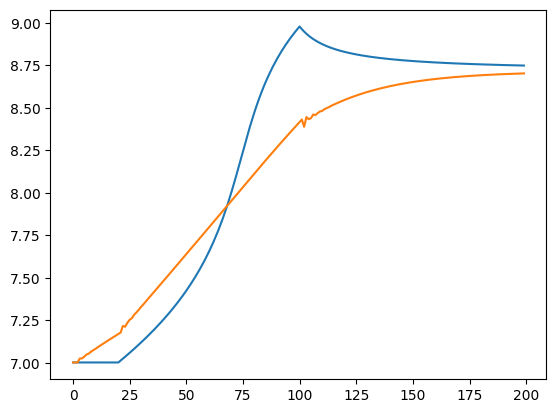

In [14]:
print(mse(Y_off, Y_pred))
plt.plot(Y_off)
plt.plot(Y_pred)

In [18]:
print(pre)

min_vals:[7.77500000e+00 5.54058448e-03 5.71566559e+00]
max_vals:[23.325       4.98602873  9.48785654]


In [19]:
with open("models/preprocessor.obj", "wb") as f:
    pickle.dump(pre, f)